In [128]:
import pandas as pd

import math
import matplotlib
import numpy as np

# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

from ai import cs
from keras.layers import Reshape, Softmax
from scipy.fft import fft, ifft, fftfreq, dct, idct
from scipy import signal

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D
from keras.utils import np_utils

import random
import filterpy

In [7]:
input = open("data_noise_sinus/data_noise_sinus.txt").readlines()
input2 = open("data_noise_multitone/data_noise_multitone.txt").readlines()
input

['\n',
 '\n',
 '\n',
 '2022-12-02 22:20:21:565089  ->     Device used:genmet0\n',
 '\n',
 '2022-12-02 22:20:21:565089  ->     Theta   Phi             X              Y              Z                      |0>            |1>\n',
 '2022-12-02 22:20:21:628247  ->      36.0    56.9           0.3209906789   0.4923987072   0.8090169944           0.9510565163   0.1687547866 +0.2588693199 *i\n',
 '2022-12-02 22:20:22:180768  ->      35.6    48.9           0.3826732306   0.4386665601   0.8131007610           0.9521293927   0.2009565262 +0.2303607910 *i\n',
 '2022-12-02 22:20:22:733142  ->      38.3    26.6           0.5541780472   0.2775116939   0.7847763705           0.9446630009   0.2933204998 +0.1468839648 *i\n',
 '2022-12-02 22:20:23:284986  ->      38.7    60.6           0.3069339669   0.5447200375   0.7804304073           0.9435121640   0.1626550132 +0.2886661446 *i\n',
 '2022-12-02 22:20:23:840155  ->      38.1    38.2           0.4849018958   0.3815801654   0.7869350220           0.945234

In [8]:
def parse_line(line: str):
    strings = [x for x in line.split(" ") if x != "" and x != "->"][0:-1]
    strings = [float(x) if i > 1 else x for i, x in enumerate(strings)]
    datetime_str = strings[0] + 'T' + strings[1]
    datetime_str = datetime_str[:19] + "." + datetime_str[20:]
    strings = [pd.Timestamp(datetime_str)] + strings[2:]
    return strings


columns = ['datetime', 'Theta', 'Phi', 'X', 'Y', 'Z', '|0>', '|1> r', '|1> i']
data = [parse_line(l) for l in input[6:]]
data2 = [parse_line(l) for l in input2[6:]]

In [9]:
df = pd.DataFrame(data, columns=columns)
df2 = pd.DataFrame(data2, columns=columns)
df

,datetime,Theta,Phi,X,Y,Z,|0>,|1> r,|1> i
0,2022-12-02 22:20:21.628247,36.0,56.9,0.320991,0.492399,0.809017,0.951057,0.168755,0.258869
1,2022-12-02 22:20:22.180768,35.6,48.9,0.382673,0.438667,0.813101,0.952129,0.200957,0.230361
2,2022-12-02 22:20:22.733142,38.3,26.6,0.554178,0.277512,0.784776,0.944663,0.293320,0.146884
3,2022-12-02 22:20:23.284986,38.7,60.6,0.306934,0.544720,0.780430,0.943512,0.162655,0.288666
4,2022-12-02 22:20:23.840155,38.1,38.2,0.484902,0.381580,0.786935,0.945234,0.256498,0.201844
...,...,...,...,...,...,...,...,...,...
8699,2022-12-02 23:40:26.075369,38.7,61.0,0.303124,0.546850,0.780430,0.943512,0.160636,0.289795
8700,2022-12-02 23:40:26.627850,38.8,40.3,0.477891,0.405281,0.779338,0.943223,0.253329,0.214838
8701,2022-12-02 23:40:27.180213,42.9,31.1,0.582879,0.351615,0.732543,0.930737,0.313128,0.188891
8702,2022-12-02 23:40:27.732510,39.6,62.5,0.294330,0.565402,0.770513,0.940881,0.156412,0.300464


In [10]:
deltas = [(df["datetime"][i+1]-df["datetime"][i]).total_seconds()  for i in range(df.shape[0]-2, 0, -1)]
average_delta = sum(deltas)/len(deltas)
average_delta

0.5522987566076781

In [11]:
df["datetime"][1] - df["datetime"][0]

Timedelta('0 days 00:00:00.552521')

In [12]:
class Filter:
    def filter_1d_array(self, array):
        raise NotImplemented


class EmptyFilter(Filter):
    def filter_1d_array(self, array):
        return array


class IIR(Filter):
    def __init__(self, r: float, start=None):
        self.r = r
        self.start = start

    def filter_1d_array(self, array):
        output = []
        if self.start is None:
            x = array[0]
        else:
            x = self.start
        for i in range(len(array)):
            x = self.r * x + (1 - self.r) * array[i]
            output.append(x)
        return output


class RunningAverage(Filter):
    def __init__(self, width: int):
        self.width = width

    def filter_1d_array(self, array):
        f = np.array([1 for _ in range(self.width)])
        return signal.convolve(f, array)


class Gaussian(Filter):
    def __init__(self, width: int, std_dev: float):
        self.width = width
        self.std_dev = std_dev

    def filter_1d_array(self, array):
        f = signal.windows.gaussian(self.width, self.std_dev)
        return signal.convolve(f, array)



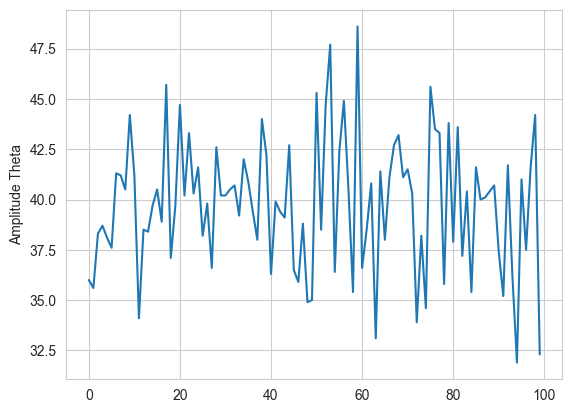

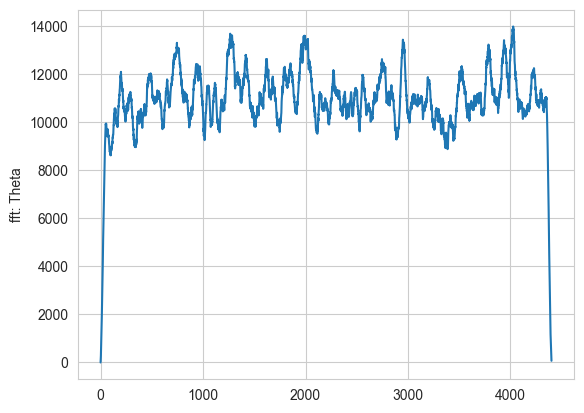

Average: 39.60754825367656
Average absolute deviation: 2.7356815087341504
std dev: 3.38896847376098


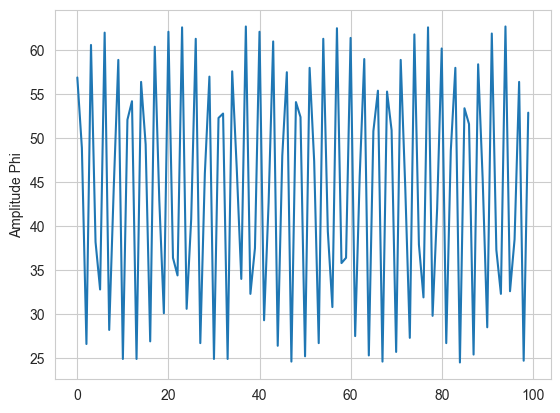

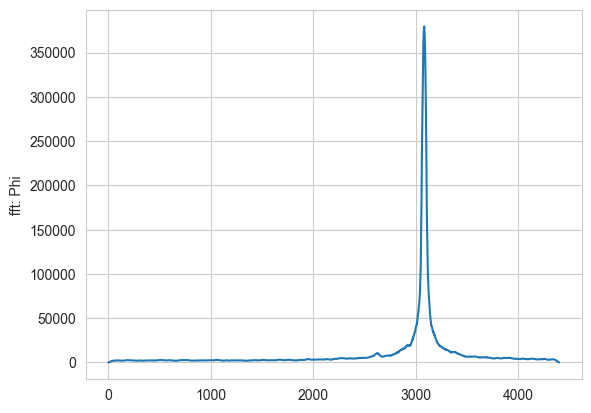

Average: 44.034673713235236
Average absolute deviation: 12.223820384728402
std dev: 13.556267778382004


[None, None]

In [13]:
def plot_with_fft(amplitude, name):
    avg = sum(amplitude) / len(amplitude)
    amplitude_offseted = list(map(lambda x: x - avg, amplitude))
    amplitude_fft = fft(amplitude_offseted)
    amplitude_fft_amplitude = np.sqrt(np.real(amplitude_fft) ** 2 + np.imag(amplitude_fft) ** 2)
    # N =len(amplitude_fft_amplitude)
    # xf = fftfreq(N, average_delta)[:N//2]
    amplitude_fft_amplitude = amplitude_fft_amplitude[0:len(amplitude_fft_amplitude) // 2]
    # f = IIR(0.9975)
    # f = RunningAverage(1)
    f = Gaussian(50, 20)
    amplitude_fft_real_filtered = f.filter_1d_array(amplitude_fft_amplitude)

    plt.plot(amplitude[:100])
    plt.ylabel(f"Amplitude {name}")
    plt.show()

    plt.plot(amplitude_fft_real_filtered)
    plt.ylabel(f"fft: {name}")
    plt.show()

    abs_dev = [abs(a - avg) for a in amplitude]
    square_dev = [(a - avg)**2 for a in amplitude]
    print(f"Average: {avg}")
    print(f"Average absolute deviation: {sum(abs_dev) / len(abs_dev)}")
    print(f"std dev: {math.sqrt(sum(square_dev) / len(square_dev))}")


[plot_with_fft([d[i] for d in data], df.columns[i]) for i in range(1, 3)]
# [plot_fft([d[i] for d in data], df.columns[i]) for i in range(1, 9)]

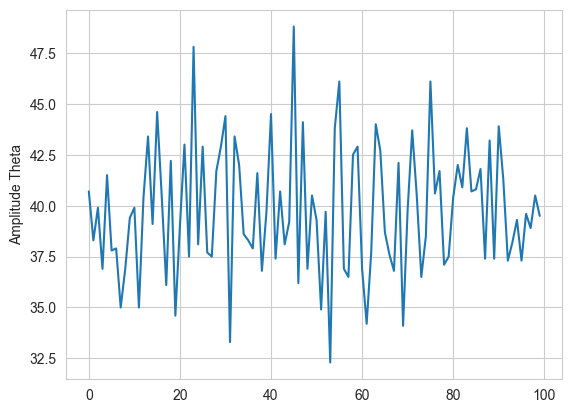

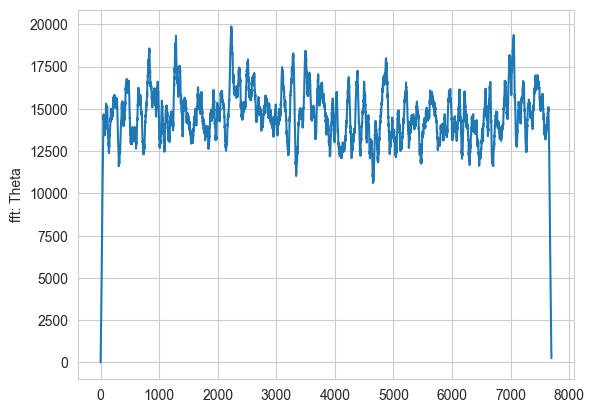

Average: 39.63496699993464
Average absolute deviation: 2.7382034272354545
std dev: 3.389891982154974


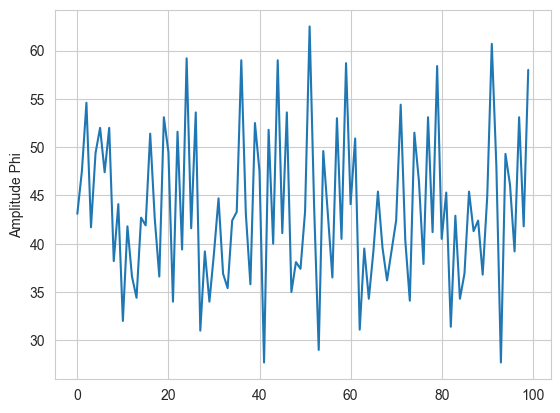

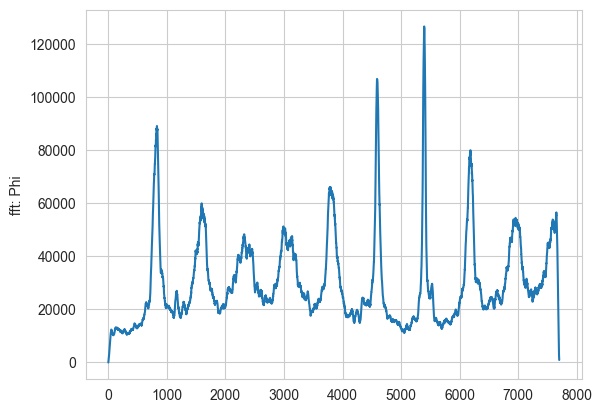

Average: 43.17478272234202
Average absolute deviation: 6.40186119665678
std dev: 8.008529476773695


[None, None]

In [14]:
[plot_with_fft([d[i] for d in data2], df.columns[i]) for i in range(1, 3)]

### Corellation

In [15]:
np.corrcoef([d[1] for d in data], [d[2] for d in data])

array([[ 1.        , -0.02485286],
       [-0.02485286,  1.        ]])

In [16]:
np.corrcoef([d[1] for d in data2], [d[2] for d in data2])

array([[ 1.        , -0.01848771],
       [-0.01848771,  1.        ]])

### My labels

In [17]:
N = len(data)
N

8704

In [18]:
my_theta = [random.gauss(mu=39.60754825367656, sigma = 3.38896847376098) for _ in range(N)]
my_theta

[44.33730155963741,
 37.61306898941681,
 41.62766382245664,
 34.16707710768456,
 39.31150441634367,
 41.68656496965127,
 40.385057261391,
 41.01519274971854,
 38.643555299341116,
 42.24537492575397,
 36.378174161448655,
 34.83928126707466,
 39.05540291556435,
 45.42673835274817,
 36.36343644279917,
 29.424740946456804,
 38.40261074991872,
 45.74164556771953,
 40.99817497130891,
 43.601569828421056,
 41.280558307387814,
 41.79646090305013,
 38.18312566907718,
 40.83284623868957,
 43.19016606343672,
 35.38495449977307,
 39.23539131813744,
 38.430106565623156,
 30.618606075142786,
 38.779839287947155,
 38.05859912234873,
 43.59565166289773,
 39.654165883102074,
 39.25813104705126,
 37.07036219976767,
 35.925212719130656,
 39.2660905901083,
 40.76431553001686,
 46.9714097561308,
 38.22305889430149,
 39.38880508403874,
 39.448442785337505,
 33.65491524472708,
 33.08430327650138,
 37.529239327844465,
 39.06721015987082,
 39.5541262598569,
 37.82372352077116,
 41.391994681188564,
 38.49870964

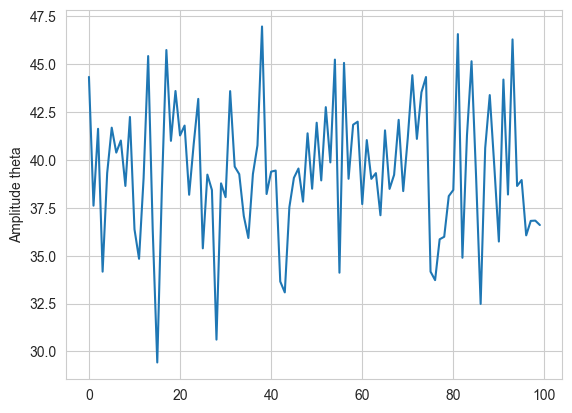

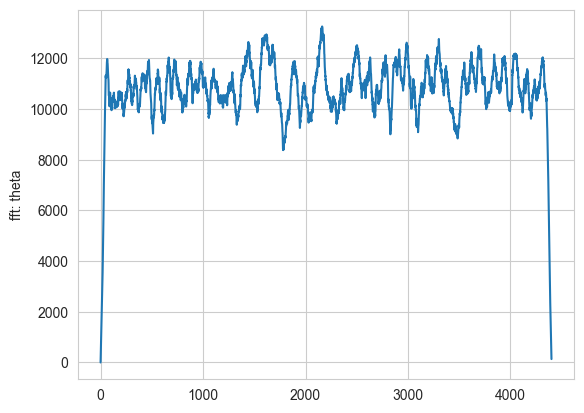

Average: 39.53213460482506
Average absolute deviation: 2.664346496664907
std dev: 3.3309885774390233


In [19]:
plot_with_fft(my_theta, "theta")

In [20]:
T = average_delta
x = np.linspace(0.0, N*T, N, endpoint=False)
my_phi = np.sin(50.0 * 2.0*np.pi*x) * 19 + 44.034673713235236
my_phi

array([44.03467371, 31.47531644, 62.88298688, ..., 35.50875923,
       61.65613166, 26.1153848 ])

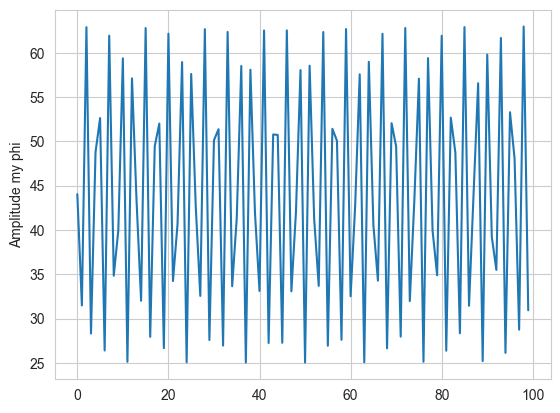

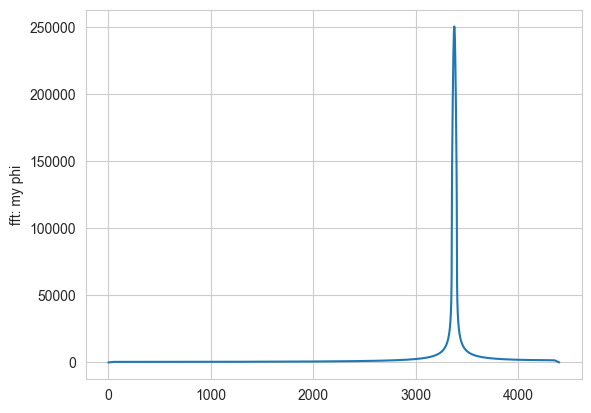

Average: 44.03336919082355
Average absolute deviation: 12.09567508166044
std dev: 13.435218170588112


In [21]:
plot_with_fft(my_phi, "my phi")

In [22]:
def plot(amplitude):
    f, ax = plt.subplots(1)
    ax.plot(amplitude)
    ax.set_ylim(ymin=0)
    plt.show(f)

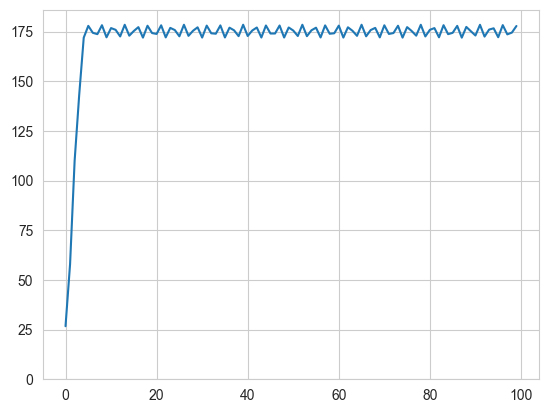

In [23]:
# f = IIR(0.9)
# f = RunningAverage(5)
f = Gaussian(5, 2)
my_phi_filtered = f.filter_1d_array(my_phi)
plot(my_phi_filtered[:100])

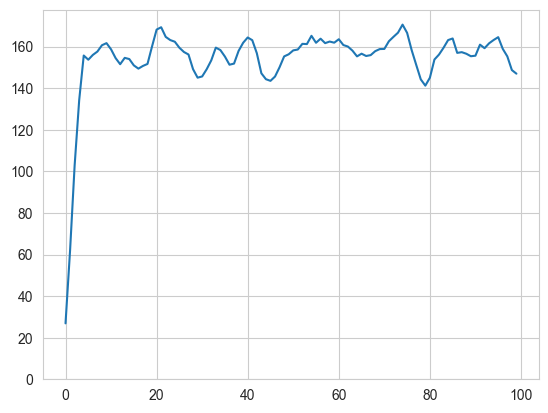

In [24]:
# f = EmptyFilter()
f = Gaussian(5, 2)
my_theta_filtered = f.filter_1d_array(my_theta)
plot(my_theta_filtered[:100])

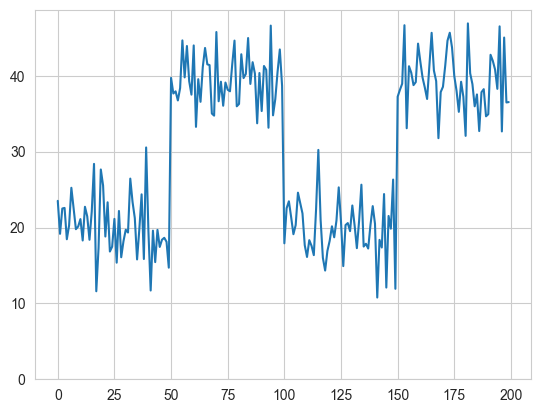

In [25]:
my_theta_mixed = [random.gauss(mu=39.60754825367656, sigma = 3.38896847376098) if i%2 else random.gauss(mu=20, sigma = 3.38896847376098) for i in range(N//50) for _ in range(50)]
# plot(my_theta_mixed)
plot(my_theta_mixed[:200])

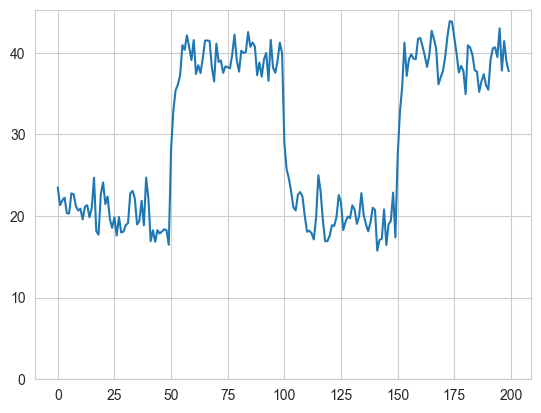

In [26]:
# f = EmptyFilter()
f = IIR(0.5)
# f = RunningAverage(5)
# f = Gaussian(5, 2)
my_theta_mixed_filtered = f.filter_1d_array(my_theta_mixed)
plot(my_theta_mixed_filtered[:200])

## Mix two real signal sources

In [27]:
N2 = min(len(data), len(data2))
i = 0
mixed_sources = []
mixed_sources_labels = []
first = True
while i < N2:
    for j in range(random.randint(5, 100)):
        if first:
            mixed_sources.append(data[i])
            mixed_sources_labels.append(0)
        else:
            mixed_sources.append(data2[i])
            mixed_sources_labels.append(1)
        i += 1
    first = not first

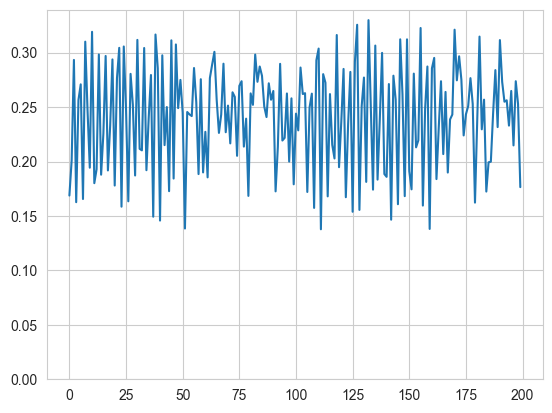

In [28]:
plot([x[7] for x in mixed_sources[:200]])

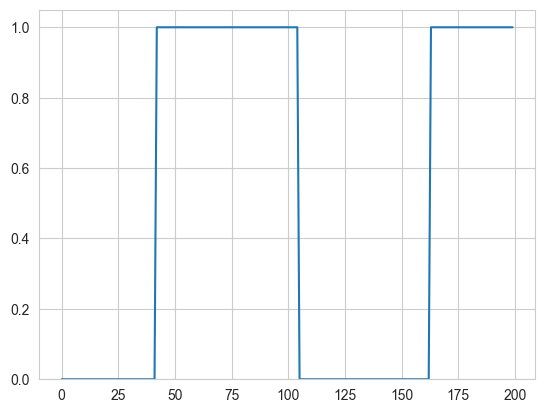

In [29]:
plot(mixed_sources_labels[:200])

### Try using RNN

In [107]:
mixed_sources_ys = np_utils.to_categorical(mixed_sources_labels, 2)
mixed_sources_ys

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [114]:
# mixed_sources_xs_train = [x[7] for x in mixed_sources[:int(N*0.6)]]
# mixed_sources_xs_val = [x[7] for x in mixed_sources[int(N*0.6):int(N*0.8)]]
# mixed_sources_xs_test = [x[7] for x in mixed_sources[int(N*0.8):]]
#
# mixed_sources_ys_train = mixed_sources_labels[:int(N*0.6)]
# mixed_sources_ys_val = mixed_sources_labels[int(N*0.6):int(N*0.8)]
# mixed_sources_ys_test = mixed_sources_labels[int(N*0.8):]

mixed_sources_xs_train = [x[7] for x in mixed_sources[:int(N*0.7)]]
mixed_sources_xs_test = [x[7] for x in mixed_sources[int(N*0.7):]]

mixed_sources_ys_train = mixed_sources_ys[:int(N*0.7)]
mixed_sources_ys_test = mixed_sources_ys[int(N*0.7):]

window_size = 20

In [115]:
def into_windows(array, window_len):
    N = len(array)
    output = []
    for i in range(N - window_len + 1):
        output.append(array[i:i+window_len])
    return np.array(output)

In [116]:
xs_windowed_train = into_windows(mixed_sources_xs_train, window_size)
ys_windowed_train = into_windows(mixed_sources_ys_train, window_size)
# xs_windowed_val = into_windows(mixed_sources_xs_val, window_size)
# ys_windowed_val = into_windows(mixed_sources_ys_val, window_size)
xs_windowed_test = into_windows(mixed_sources_xs_test, window_size)
ys_windowed_test = into_windows(mixed_sources_ys_test, window_size)

xs_windowed_train /= 90
xs_windowed_test /= 90

In [149]:
model = Sequential()
model.add(Dense(512, input_shape=(window_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(2*window_size))
model.add(Reshape((window_size, 2)))
model.add(Softmax(axis=2)) # w celu zapewnienia rozkładu wyjść sumującego się do 1
# model.add(Activation('softmax')) # w celu zapewnienia rozkładu wyjść sumującego się do 1

In [150]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [151]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 512)               10752     
                                                                 
 activation_44 (Activation)  (None, 512)               0         
                                                                 
 dropout_36 (Dropout)        (None, 512)               0         
                                                                 
 dense_56 (Dense)            (None, 512)               262656    
                                                                 
 activation_45 (Activation)  (None, 512)               0         
                                                                 
 dropout_37 (Dropout)        (None, 512)               0         
                                                                 
 dense_57 (Dense)            (None, 40)              

In [152]:
import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

In [153]:
model.fit(xs_windowed_train, ys_windowed_train,
          batch_size=128, epochs=16,
          verbose=1,
          validation_data=(xs_windowed_test, ys_windowed_test), callbacks = time_callback)

Epoch 1/16
48/48 [==============================] - 1s 10ms/step - loss: 0.2500 - accuracy: 0.5057 - val_loss: 0.2499 - val_accuracy: 0.5073
Epoch 2/16
48/48 [==============================] - 0s 7ms/step - loss: 0.2500 - accuracy: 0.5053 - val_loss: 0.2499 - val_accuracy: 0.5073
Epoch 3/16
48/48 [==============================] - 0s 7ms/step - loss: 0.2500 - accuracy: 0.5068 - val_loss: 0.2499 - val_accuracy: 0.5073
Epoch 4/16
48/48 [==============================] - 0s 8ms/step - loss: 0.2500 - accuracy: 0.5063 - val_loss: 0.2499 - val_accuracy: 0.5073
Epoch 5/16
48/48 [==============================] - 0s 7ms/step - loss: 0.2500 - accuracy: 0.5068 - val_loss: 0.2499 - val_accuracy: 0.5073
Epoch 6/16
48/48 [==============================] - 0s 7ms/step - loss: 0.2500 - accuracy: 0.5068 - val_loss: 0.2499 - val_accuracy: 0.5073
Epoch 7/16
48/48 [==============================] - 0s 6ms/step - loss: 0.2500 - accuracy: 0.5068 - val_loss: 0.2499 - val_accuracy: 0.5073
Epoch 8/16
48/48 [=

In [156]:
model.predict(xs_windowed_test[:1])

1/1 [==============================] - 0s 17ms/step


array([[[0.49474126, 0.50525874],
        [0.4944037 , 0.5055963 ],
        [0.49400207, 0.50599796],
        [0.49431685, 0.5056832 ],
        [0.4936973 , 0.50630265],
        [0.49353743, 0.50646263],
        [0.49297172, 0.50702834],
        [0.4929797 , 0.5070203 ],
        [0.49339977, 0.5066002 ],
        [0.49332   , 0.5066801 ],
        [0.49381608, 0.5061839 ],
        [0.49346554, 0.50653446],
        [0.49313906, 0.506861  ],
        [0.4932516 , 0.50674844],
        [0.49327725, 0.5067227 ],
        [0.49360678, 0.50639325],
        [0.49391875, 0.5060813 ],
        [0.49334538, 0.50665456],
        [0.49358773, 0.50641227],
        [0.4934664 , 0.5065336 ]]], dtype=float32)

In [157]:
ys_windowed_test[:1]

array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)